In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import cv2
import tqdm as tqdm
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
akhila = "/content/drive/MyDrive/BCA PROJECT/vainid_image capture/akhila"
anaida = "/content/drive/MyDrive/BCA PROJECT/vainid_image capture/anaida"
jithu = "/content/drive/MyDrive/BCA PROJECT/vainid_image capture/jithu"
nifiya = "/content/drive/MyDrive/BCA PROJECT/vainid_image capture/nifiya"
veena = "/content/drive/MyDrive/BCA PROJECT/vainid_image capture/veena"

In [5]:
print("Number of Images in Each Directory:")
print(f"akhila: {len(os.listdir(akhila))}")
print(f"anaida: {len(os.listdir(anaida))}")
print(f"jithu: {len(os.listdir(jithu))}")
print(f"nifiya: {len(os.listdir(nifiya))}")
print(f"veena: {len(os.listdir(veena))}")

Number of Images in Each Directory:
akhila: 500
anaida: 500
jithu: 500
nifiya: 500
veena: 500


<h3>Data preprocessing for our Model</h3>

In [6]:
x = []
y = [] 
dataset =[]
def create_dataset(directory,dir_name):
    for i in tqdm.tqdm(os.listdir(directory)):
        full_path = os.path.join(directory,i)
        try:
            img = cv2.imread(full_path)
            img = cv2.resize(img,(150,150))
        except:
            continue
        x.append(img)
        y.append(dir_name)
    return x,y

In [7]:
x,y= create_dataset(akhila,"akhila")
x,y= create_dataset(anaida,"anaida")
x,y= create_dataset(jithu,"jithu")
x,y= create_dataset(nifiya,"nifiya")
x,y= create_dataset(veena,"veena")

100%|██████████| 500/500 [00:07<00:00, 63.92it/s] 


In [9]:
x =  np.array(x)
y = np.array(y)
x.shape,y.shape

((2500, 150, 150, 3), (2500,))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


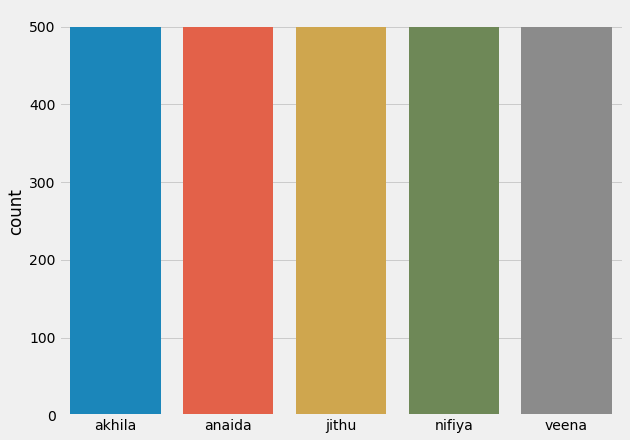

In [10]:
import seaborn as sns
plt.figure(figsize=(9,7))
plt.style.use("fivethirtyeight")
sns.countplot(y)
plt.show()

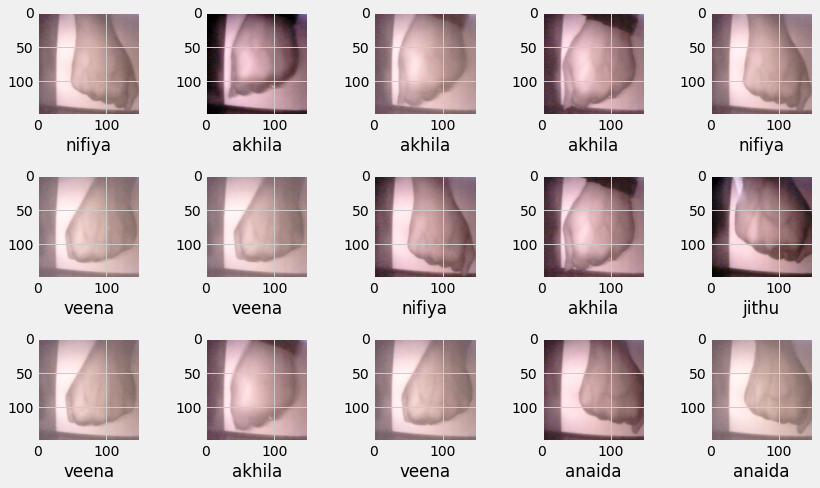

In [11]:
fig = plt.figure(figsize=(12,7))
for i in range(15):
    sample =  random.choice(range(len(x)))
    image = x[sample]
    category = y[sample]
    plt.subplot(3,5,i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image)
    plt.xlabel(category)
    
plt.tight_layout()
plt.show()

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [13]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [14]:
img_size =150

x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0


x_train = x_train.reshape(-1,img_size,img_size,3)
y_train = np.array(y_train)

x_test = x_test.reshape(-1,img_size,img_size,3)
y_test = np.array(y_test)

In [15]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_test_lb = lb.fit_transform(y_test)

In [16]:
y_train_lb.shape,y_test_lb.shape

((2000, 5), (500, 5))

><h3>Model building</h3>

In [17]:
import tensorflow as tf

vgg=tf.keras.applications.vgg19.VGG19(weights = "imagenet",include_top=False,input_shape=(img_size,img_size,3))

80134624/80134624 [==============================] - 4s 0us/step


In [18]:
for layer in vgg.layers:
    layer.trainable = False

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model =Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(5,activation="softmax"))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 5)                 40965     
                                                                 
Total params: 20,065,349
Trainable params: 40,965
Non-trainable params: 20,024,384
_________________________________________________________________


In [21]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics="accuracy")

#model.compile(optimizer="adadelta",loss="categorical_crossentropy",metrics="accuracy")

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19_26-06.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [22]:
unique,counts = np.unique(y_train_lb,return_counts=True)
print(unique,counts)

[0 1] [8000 2000]


In [23]:
batch_size=32
history =  model.fit(x_train,y_train_lb,epochs=60,validation_data=(x_test,y_test_lb),
                     batch_size=32 ,verbose=1,callbacks=[checkpoint,earlystop])


Epoch 1/60
63/63 [==============================] - ETA: 0s - loss: 0.2902 - accuracy: 0.9260
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to vgg19_26-06.h5
63/63 [==============================] - 19s 147ms/step - loss: 0.2902 - accuracy: 0.9260 - val_loss: 0.0281 - val_accuracy: 1.0000
Epoch 2/60
62/63 [============================>.] - ETA: 0s - loss: 0.0198 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
63/63 [==============================] - 6s 99ms/step - loss: 0.0197 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 1.0000
Epoch 3/60
62/63 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
63/63 [==============================] - 6s 99ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 4/60
63/63 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 1.0

In [25]:
loss,accuracy = model.evaluate(x_test,y_test_lb)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")     

16/16 [==============================] - 1s 81ms/step - loss: 0.0033 - accuracy: 1.0000
Loss: 0.003270679386332631
Accuracy: 1.0


In [26]:
y_pred = model.predict(x_test)
classes_x=np.argmax(y_pred,axis=1)
y_pred =classes_x
y_pred[:15]
y_pred=classes_x

16/16 [==============================] - 1s 79ms/step


><h3>Classification Report</h3>

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00        88
           2       1.00      1.00      1.00       108
           3       1.00      1.00      1.00       111
           4       1.00      1.00      1.00        93

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



><h3>Confusion Matrix</h3>

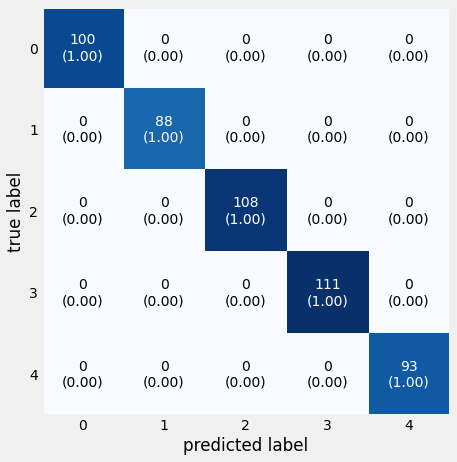

In [28]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
class_names = ["akhila","anaida","jithu","nifiya","veena"]
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),
                      show_normed = True);

><h3>Learning Curve:</h3>

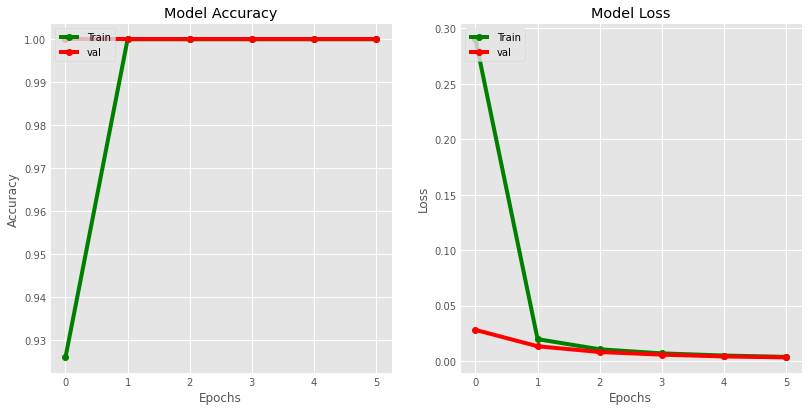

In [29]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(6)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

## TEST

In [30]:
class_names=["akhila","anaida","jithu","nifiya","veena"]

In [31]:
#load model 
from tensorflow import keras
model.load_weights('/content/vgg19_26-06.h5')

In [32]:
photo="/content/drive/MyDrive/BCA PROJECT/anaida/vein12.jpg"

img = tf.keras.utils.load_img(
    photo, target_size=(150, 150)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = img_array/255.0
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

score

1/1 [==============================] - 1s 604ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.28676873, 0.16738683, 0.16265304, 0.21867783, 0.16451357],
      dtype=float32)>

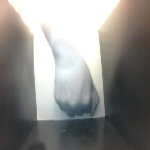

In [33]:
img

In [34]:
if 100 * np.max(score) > 35.00:
  print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))
     
else:
   print("Unknown person") 

Unknown person


In [38]:
photo="/content/drive/MyDrive/BCA PROJECT/vainid_image capture/veena/vein100.jpg"

img = tf.keras.utils.load_img(
    photo, target_size=(150, 150)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = img_array/255.0
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

score

1/1 [==============================] - 0s 104ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.14978422, 0.14928828, 0.14911555, 0.1491347 , 0.40267727],
      dtype=float32)>

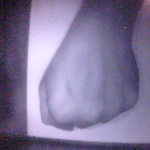

In [39]:
img

In [40]:
if 100 * np.max(score) >= 39.22:
  print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))
     
else:
   print("Unknown person") 

This image most likely belongs to veena with a 40.27 percent confidence.
